<a href="https://colab.research.google.com/github/RuxandraFiloti/RuxandraFiloti/blob/main/COVID19_Data_Analysis_and_Prediction_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Data Analysis and Prediction (Updated)

Acest notebook utilizează o conexiune la BigQuery printr-un fișier JSON pentru autentificare, procesează datele relevante și generează grafice și predicții pe baza lor.

**Coloanele utilizate din dataset:**
- `date`
- `state_name`
- `confirmed_new`
- `deaths_new`
- `population`

In [ ]:

from pyspark.sql import SparkSession
from google.cloud import bigquery
import os

# Setăm calea către fișierul JSON pentru autentificare
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "unique-nebula-438315-t3-0502e35d6c01.json"

# Creează o sesiune Spark
spark = SparkSession.builder \
    .appName("BigQuery to PySpark") \
    .getOrCreate()

# Conexiunea la BigQuery
#project_id = "unique-nebula-438315"
#dataset = "dataflix_covid_dataset"
#table = "bi_usa_daily_trends"

service_account_key_path = "unique-nebula-438315-t3-0502e35d6c01.json"
client = bigquery.Client.from_service_account_json(service_account_key_path)

query = f"""
    SELECT date, state_name, confirmed_new, deaths_new, population
    FROM `covid-assistant.covid.bi_usa_daily_trends`
    WHERE state_name IS NOT NULL

"""
query_job = client.query(query)

# Convertim rezultatul în Pandas DataFrame și apoi în Spark DataFrame
pandas_df = query_job.to_dataframe()
spark_df = spark.createDataFrame(pandas_df)
spark_df.show(5)


+----------+----------+-------------+----------+----------+
|      date|state_name|confirmed_new|deaths_new|population|
+----------+----------+-------------+----------+----------+
|2023-03-03|   Alabama|          0.0|       0.0|   55601.0|
|2023-03-03|   Alabama|          0.0|       0.0|   24881.0|
|2023-03-03|   Alabama|          0.0|       0.0|  114277.0|
|2023-03-03|   Alabama|          0.0|       0.0|   44153.0|
|2023-03-03|   Alabama|          0.0|       0.0|   12277.0|
+----------+----------+-------------+----------+----------+
only showing top 5 rows



In [ ]:
# se transforma NaN in 0.0 pentru a desena graficul
from pyspark.sql.functions import col, when, isnan

# Replace NaN values with 0.0 in specified columns
spark_df = spark_df.withColumn("confirmed_new", when(isnan("confirmed_new"), 0.0).otherwise(col("confirmed_new"))) \
                   .withColumn("deaths_new", when(isnan("deaths_new"), 0.0).otherwise(col("deaths_new"))) \
                   .withColumn("population", when(isnan("population"), 0.0).otherwise(col("population")))

spark_df.show(5)  # Display the updated DataFrame (optional)

+----------+----------+-------------+----------+----------+
|      date|state_name|confirmed_new|deaths_new|population|
+----------+----------+-------------+----------+----------+
|2023-03-03|   Alabama|          0.0|       0.0|   55601.0|
|2023-03-03|   Alabama|          0.0|       0.0|   24881.0|
|2023-03-03|   Alabama|          0.0|       0.0|  114277.0|
|2023-03-03|   Alabama|          0.0|       0.0|   44153.0|
|2023-03-03|   Alabama|          0.0|       0.0|   12277.0|
+----------+----------+-------------+----------+----------+
only showing top 5 rows



In [ ]:
#transforma datele raw in date agregate despre nr total de cazuri cofirmate per stat
statewise_cases_df = spark_df.groupBy("state_name").sum("confirmed_new")
statewise_cases_df = statewise_cases_df.withColumnRenamed("sum(confirmed_new)", "total_confirmed_new")
statewise_cases_df.show()


+--------------------+-------------------+
|          state_name|total_confirmed_new|
+--------------------+-------------------+
|                Utah|           816235.0|
|              Hawaii|           381064.0|
|           Minnesota|          1789052.0|
|                Ohio|          3404659.0|
|United States Vir...|                0.0|
|Northern Mariana ...|            13891.0|
|            Arkansas|          1009635.0|
|              Oregon|           966628.0|
|               Texas|          8480241.0|
|        North Dakota|           287863.0|
|        Pennsylvania|          3523221.0|
|         Connecticut|           977222.0|
|            Nebraska|           568551.0|
|             Vermont|           152760.0|
|      American Samoa|             8317.0|
|              Nevada|           891520.0|
|       Wuhan Evacuee|                0.0|
|         Puerto Rico|          1099986.0|
|          Washington|          1926823.0|
|            Illinois|          4087876.0|
+----------

In [ ]:
#arata nr de morti per an si luna pentru analiza si foloseste PySpark
from pyspark.sql.functions import month, year

monthly_deaths_df = spark_df.withColumn("month", month("date")).withColumn("year", year("date")) \
    .groupBy("year", "month").sum("deaths_new")
monthly_deaths_df = monthly_deaths_df.withColumnRenamed("sum(deaths_new)", "total_deaths_new")
monthly_deaths_df.show()


+----+-----+----------------+
|year|month|total_deaths_new|
+----+-----+----------------+
|2022|   10|         10711.0|
|2020|    6|         23004.0|
|2021|    8|         26810.0|
|2021|    6|         10110.0|
|2021|    5|         18605.0|
|2021|   10|         47829.0|
|2020|   11|         37218.0|
|2020|    3|          2688.0|
|2020|    9|         23268.0|
|2022|    2|         66806.0|
|2022|    7|         12611.0|
|2021|   11|         34137.0|
|2021|    9|         57521.0|
|2022|   11|         10182.0|
|2022|    3|         29881.0|
|2020|   12|         77449.0|
|2023|    3|          3939.0|
|2021|   12|         45146.0|
|2021|    7|          8388.0|
|2023|    2|         11379.0|
+----+-----+----------------+
only showing top 20 rows



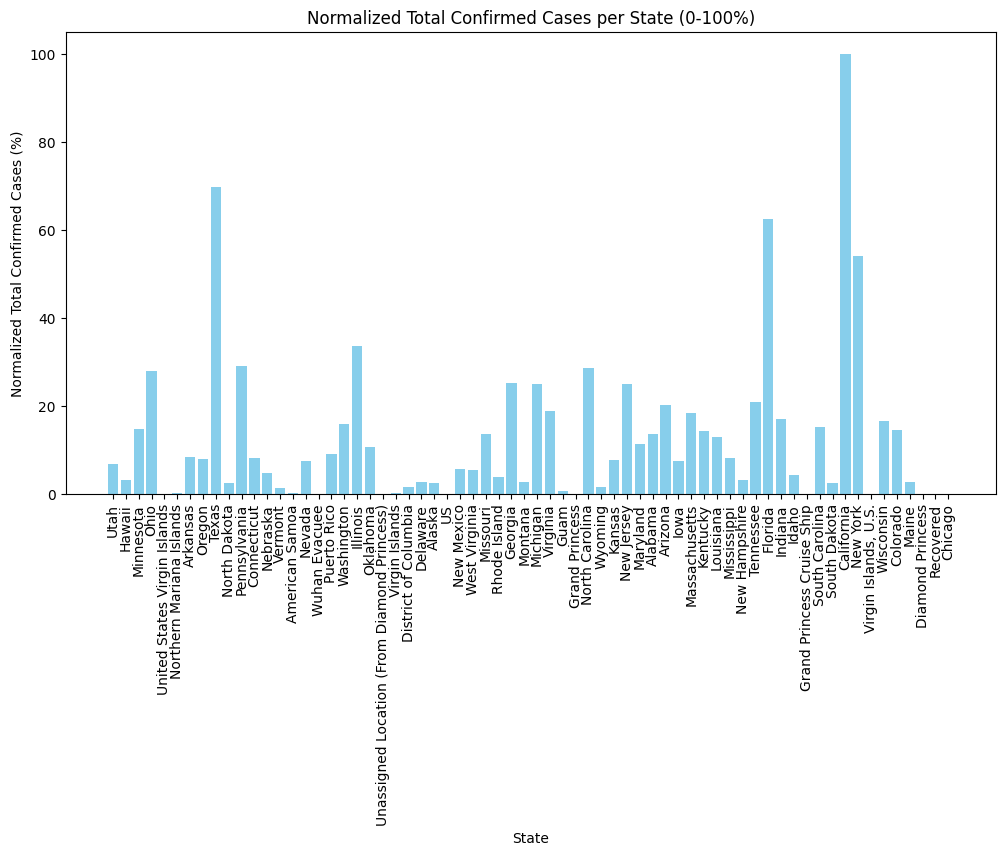

In [ ]:

import matplotlib.pyplot as plt

#Grafic pentru toate cazurile confirmate
max_cases = statewise_cases_pandas['total_confirmed_new'].max()

# Normalize the values
statewise_cases_pandas['normalized_cases'] = (statewise_cases_pandas['total_confirmed_new'] / max_cases) * 100

# Updated plotting code
plt.figure(figsize=(12, 6))
plt.bar(statewise_cases_pandas['state_name'], statewise_cases_pandas['normalized_cases'], color='skyblue')
plt.title("Normalized Total Confirmed Cases per State (0-100%)")
plt.xlabel("State")
plt.ylabel("Normalized Total Confirmed Cases (%)")
plt.xticks(rotation=90)
plt.show()


+----+-----+----------------+
|year|month|total_deaths_new|
+----+-----+----------------+
|2020|    1|             0.0|
|2020|    2|             0.0|
|2020|    3|          2688.0|
|2020|    4|         58924.0|
|2020|    5|         41330.0|
|2020|    6|         23004.0|
|2020|    7|         25843.0|
|2020|    8|          9743.0|
|2020|    9|         23268.0|
|2020|   10|         23478.0|
|2020|   11|         37218.0|
|2020|   12|         77449.0|
|2021|    1|         95328.0|
|2021|    2|         71592.0|
|2021|    3|         38834.0|
|2021|    4|         23826.0|
|2021|    5|         18605.0|
|2021|    6|         10110.0|
|2021|    7|          8388.0|
|2021|    8|         26810.0|
+----+-----+----------------+
only showing top 20 rows



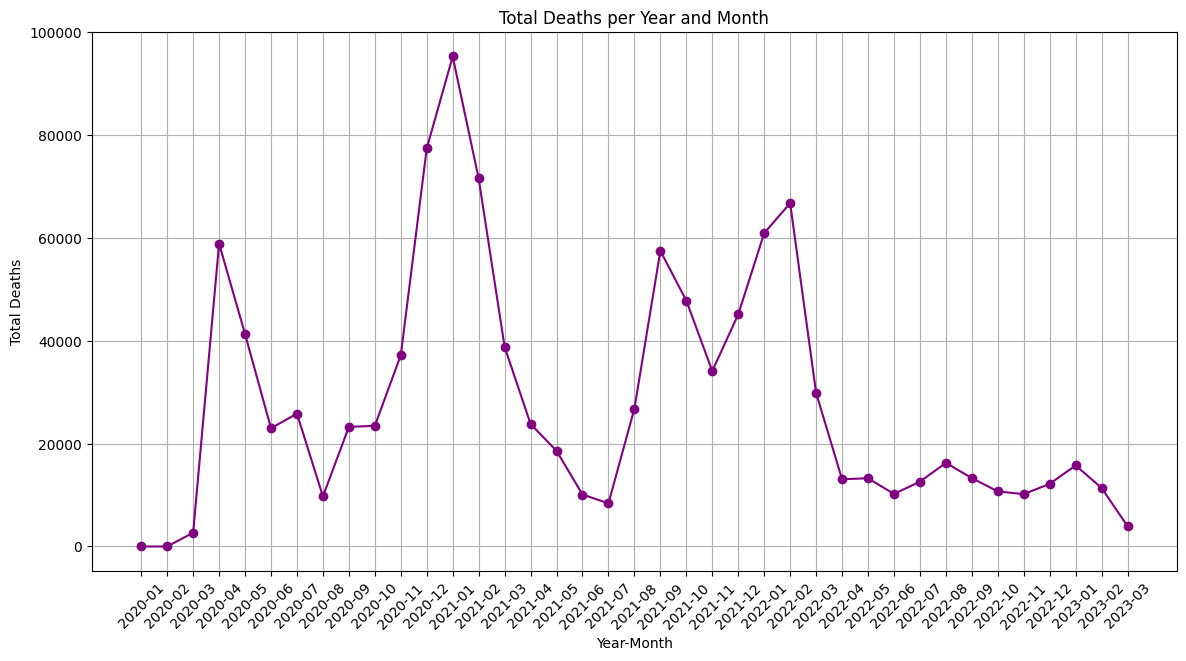

In [ ]:
from pyspark.sql.functions import year, month

# Calculate total deaths per year and month
year_month_deaths_df = spark_df.withColumn("year", year("date")) \
    .withColumn("month", month("date")) \
    .groupBy("year", "month").sum("deaths_new")
year_month_deaths_df = year_month_deaths_df.withColumnRenamed("sum(deaths_new)", "total_deaths_new")
year_month_deaths_df = year_month_deaths_df.orderBy("year", "month")  # Order by year and month
year_month_deaths_df.show()

# Convert to Pandas DataFrame for plotting
year_month_deaths_pandas = year_month_deaths_df.toPandas()
year_month_deaths_pandas['year_month'] = (
    year_month_deaths_pandas['year'].astype(str) + "-" + year_month_deaths_pandas['month'].astype(str).str.zfill(2)
)

import matplotlib.pyplot as plt

# Plot total deaths per year and month
plt.figure(figsize=(14, 7))
plt.plot(
    year_month_deaths_pandas['year_month'],
    year_month_deaths_pandas['total_deaths_new'],
    marker='o',
    color='purple',
)
plt.title('Total Deaths per Year and Month')
plt.xlabel('Year-Month')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Selectăm coloanele pentru predicție
feature_cols = ["deaths_new", "population"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(spark_df.select("confirmed_new", *feature_cols).na.drop())

# Împărțim datele
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


In [ ]:

# Antrenare model cu regresie liniara
#prediction = valorile prezise cu regresie
#confirmed_new = numarul actual de cazuri confirmate dupa antrenare
lr = LinearRegression(featuresCol="features", labelCol="confirmed_new")
lr_model = lr.fit(train_data)

# Evaluare
predictions = lr_model.transform(test_data)
predictions.select("prediction", "confirmed_new").show()


+-------------------+-------------+
|         prediction|confirmed_new|
+-------------------+-------------+
| 1661.2463491889966|    -276352.0|
|  4331.705434665027|     -90832.0|
|  74.08670404758256|     -76381.0|
| -5921.849733153314|     -47587.0|
|-1.4923266734371576|     -27020.0|
|   8564.13115504213|     -21059.0|
|  1048.728384808719|     -15406.0|
|-354.19447003819585|     -13101.0|
|-1462.6869206131516|      -9660.0|
|-1563.4589615745112|      -9351.0|
|-1.4923266734371576|      -9347.0|
|-1.4923266734371576|      -8680.0|
|-1.4923266734371576|      -8391.0|
|-1.4923266734371576|      -8023.0|
| -782.4756441239741|      -6852.0|
|-1.4923266734371576|      -6221.0|
|-1.4923266734371576|      -5524.0|
|  74.08670404758256|      -4053.0|
| 55.089048383768855|      -3488.0|
| 23.700683566902747|      -3301.0|
+-------------------+-------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create an evaluator object
evaluator = RegressionEvaluator(labelCol="confirmed_new", predictionCol="prediction", metricName="r2")

# Calculate R-squared is like accuracy for classification
r2 = evaluator.evaluate(predictions)
print(f"R-squared: {r2}")

# Calculate MSE
evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

R-squared: 0.014487353640162182
Mean Squared Error (MSE): 332816.90706006903


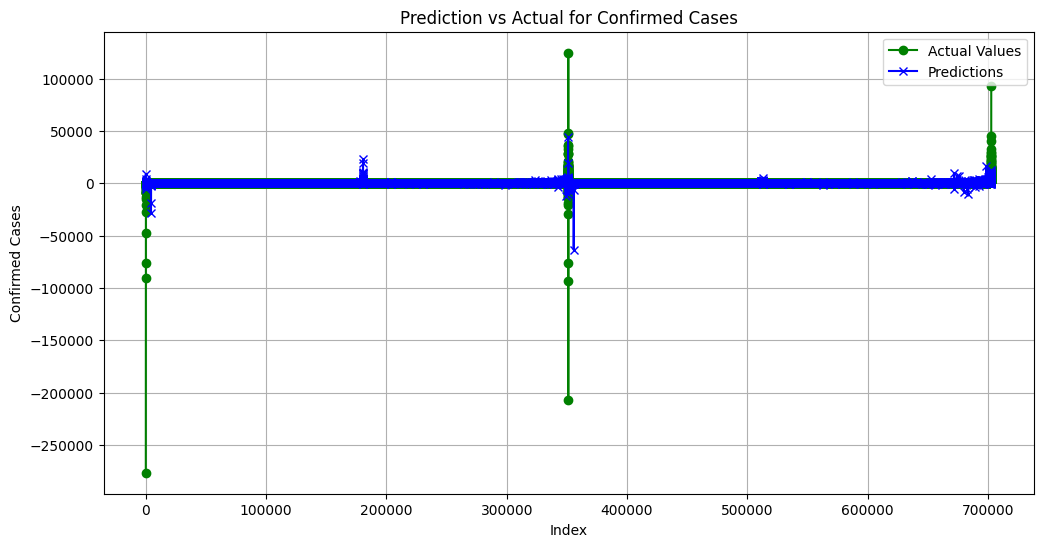

In [ ]:

# Grafic pentru compararea valorilor reale și prezise
predictions_pandas = predictions.select("prediction", "confirmed_new").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(predictions_pandas.index, predictions_pandas['confirmed_new'], label="Actual Values", marker='o', color='green')
plt.plot(predictions_pandas.index, predictions_pandas['prediction'], label="Predictions", marker='x', color='blue')
plt.title("Prediction vs Actual for Confirmed Cases")
plt.xlabel("Index")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.grid()
plt.show()


+----+-----+---------+------------------+
|year|month|   actual|         predicted|
+----+-----+---------+------------------+
|2022|    3|1055632.0| 3413173.766170036|
|2022|    4|1244462.0|3266515.5350763984|
|2022|    5|2855123.0|3374880.9092374747|
|2022|    6|3405927.0|3259954.2093072473|
|2022|    7|3675769.0|3373330.5537814014|
|2022|    8|3206854.0|3381772.1469563376|
|2022|    9|1845862.0|3267041.5485346783|
|2022|   10|1059225.0| 3261068.527291276|
|2022|   11|1331103.0|3259848.0837849556|
|2022|   12|1954615.0| 3372361.581621443|
|2023|    1|1591897.0|3380613.9945174465|
|2023|    2|1072064.0|3046852.4924319996|
|2023|    3| 380706.0|  979994.803655266|
+----+-----+---------+------------------+

R-squared: 0.05104362401537388
Mean Squared Error (MSE): 2812658.874736169


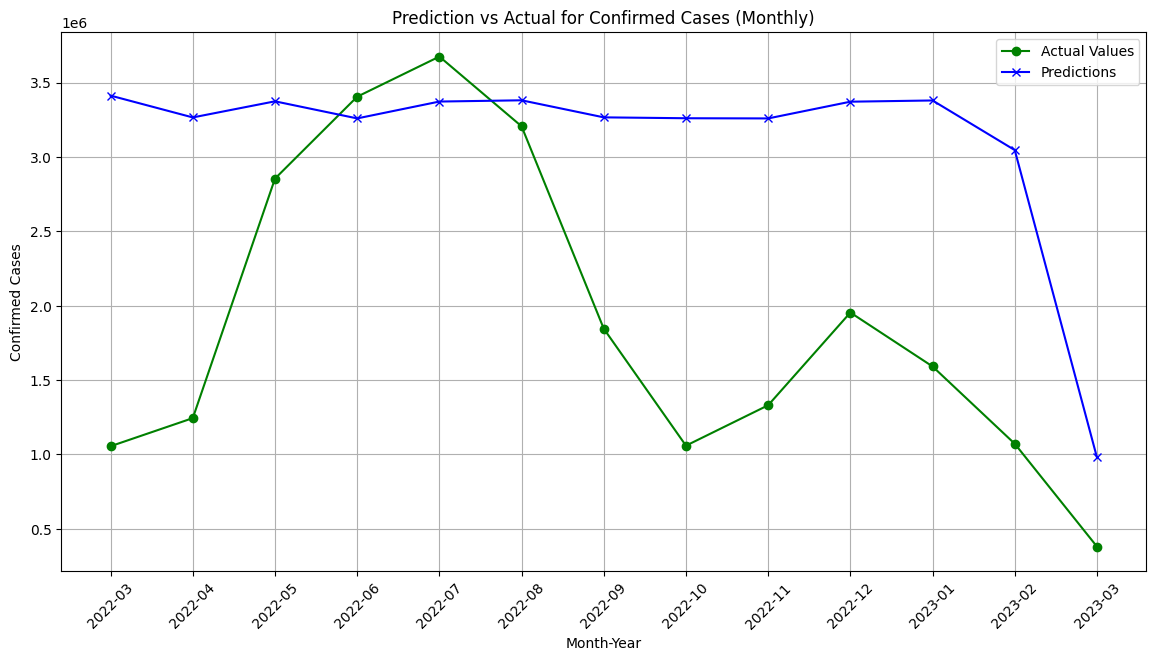

In [ ]:
from pyspark.sql.functions import year, month, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Extract year and month
spark_df = spark_df.withColumn("year", year("date")).withColumn("month", month("date"))

# Filter the last 12 months for the test dataset
last_date = spark_df.select("year", "month").orderBy(col("year").desc(), col("month").desc()).first()
last_year, last_month = last_date["year"], last_date["month"]
test_data_df = spark_df.filter(
    (col("year") == last_year) | ((col("year") == last_year - 1) & (col("month") >= last_month))
)

# Create training dataset by excluding the last 12 months
train_data_df = spark_df.subtract(test_data_df)

# Feature assembly
feature_cols = ["deaths_new", "population"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data_df.select("confirmed_new", *feature_cols, "year", "month").na.drop()) # Include 'year', 'month' here
test_data = assembler.transform(test_data_df.select("confirmed_new", *feature_cols, "year", "month").na.drop())  # Include 'year', 'month' here

# Train model
lr = LinearRegression(featuresCol="features", labelCol="confirmed_new")
lr_model = lr.fit(train_data)

# Predictions
predictions = lr_model.transform(test_data)

# Aggregate predictions and actual values per year and month
agg_predictions = (
    predictions.groupBy("year", "month")
    .agg(
        {"confirmed_new": "sum", "prediction": "sum"}
    )
    .withColumnRenamed("sum(confirmed_new)", "actual")
    .withColumnRenamed("sum(prediction)", "predicted")
    .orderBy("year", "month")
)
agg_predictions.show()

# Calculate R-squared and MSE
evaluator = RegressionEvaluator(labelCol="confirmed_new", predictionCol="prediction")

# R-squared
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R-squared: {r2}")

# Mean Squared Error (MSE)
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
print(f"Mean Squared Error (MSE): {mse}")

# Convert aggregated predictions to Pandas DataFrame for plotting
agg_predictions_pandas = agg_predictions.toPandas()
agg_predictions_pandas["month_year"] = (
    agg_predictions_pandas["year"].astype(str) + "-" + agg_predictions_pandas["month"].astype(str).str.zfill(2)
)

# Plot actual vs predicted values per month
plt.figure(figsize=(14, 7))
plt.plot(
    agg_predictions_pandas["month_year"],
    agg_predictions_pandas["actual"],
    label="Actual Values",
    marker="o",
    color="green",
)
plt.plot(
    agg_predictions_pandas["month_year"],
    agg_predictions_pandas["predicted"],
    label="Predictions",
    marker="x",
    color="blue",
)
plt.title("Prediction vs Actual for Confirmed Cases (Monthly)")
plt.xlabel("Month-Year")
plt.ylabel("Confirmed Cases")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()